In [1]:
import numpy as np
import matplotlib.ticker as mtick
import wf_psf as wf
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib inline
params = {
    "font.size": 18,
    "legend.fontsize": 18,
    "legend.frameon": False,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (7, 5),
    "xtick.top": True,
    "axes.unicode_minus": False,
    "ytick.right": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.major.pad": 8,
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "axes.linewidth": 1.5,
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True,  # needed when using cm=cmr10 for normal text
}


mpl.rcParams.update(params)


/Users/tl255879/miniconda3/envs/wf_tools/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [24]:
save_dir = './../plots/'
plot_results = True



In [2]:
from wf_psf.utils import tf_decompose_obscured_opd_basis, PI_zernikes

In [3]:

n_zernikes=20
wfe_dim=256
tol = 1e-5

# Create zernike basis
zernikes = wf.utils.zernike_generator(
    n_zernikes=n_zernikes, wfe_dim=wfe_dim
)
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# Create obscurations
obscurations = wf.SimPSFToolkit.generate_pupil_obscurations(N_pix=wfe_dim, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.float32)

# Create random zernike coefficient array
zk_array = np.random.randn(1,n_zernikes,1,1)
tf_zk_array = tf.convert_to_tensor(zk_array, dtype=tf.float32)

# Generate layer
tf_zernike_opd = wf.tf_layers.TF_zernike_OPD(tf_zernike_cube)
# Compute OPD
tf_unobscured_opd = tf_zernike_opd(tf_zk_array)
# Obscure the OPD
tf_obscured_opd = tf.math.multiply(
    tf_unobscured_opd,
    tf.expand_dims(tf_obscurations, axis=0)
)



2024-06-15 13:58:54.801372: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-15 13:58:54.801403: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-15 13:58:54.801413: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-15 13:58:54.801448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 13:58:54.801468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Compute projection with new algorithm

In [4]:
def tf_decompose_obscured_opd_basis_for_plots(
    tf_opd, tf_obscurations, tf_zk_basis, n_zernike, gt_coeffs, iters=20, 
):
    """Decompose obscured OPD into a basis using an iterative algorithm.

    Tensorflow implementation.

    Parameters
    ----------
    tf_opd: tf.Tensor(opd_dim, opd_dim)
        Input OPD that requires to be decomposed on `tf_zk_basis`.
    tf_obscurations: tf.Tensor(opd_dim, opd_dim)
        Tensor with the obscuration map.
    tf_zk_basis: Tensor(n_batch, opd_dim, opd_dim)
        Zernike polynomial maps.
    n_zernike: int
        Number of Zernike polynomials to project on.
    iters: int
        Number of iterations of the algorithm.

    Returns
    -------
    obsc_coeffs: np.ndarray(n_zernike)
        Array with projected Zernike coefficients

    Raises
    ------
        ValueError: If `n_zernike` is bigger than tf_zk_basis.shape[0].

    """
    if n_zernike > tf_zk_basis.shape[0]:
        raise ValueError(
            "Cannot project as n_zernike is bigger than the zernike elements in the provided basis tf_zk_basis."
        )
    # Clone input OPD
    input_tf_opd = tf.identity(tf_opd)
    # Clone obscurations and project
    input_tf_obscurations = tf.math.real(tf.identity(tf_obscurations))
    # Compute normalisation factor
    ngood = tf.math.reduce_sum(input_tf_obscurations, axis=None, keepdims=False).numpy()

    obsc_coeffs = np.zeros(n_zernike)
    new_coeffs = np.zeros(n_zernike)

    error_coeffs = []

    for count in range(iters):
        for i, b in enumerate(tf_zk_basis):
            this_coeff = (
                tf.math.reduce_sum(
                    tf.math.multiply(input_tf_opd, b), axis=None, keepdims=False
                ).numpy()
                / ngood
            )
            new_coeffs[i] = this_coeff

        for i, b in enumerate(tf_zk_basis):
            input_tf_opd = input_tf_opd - tf.math.multiply(
                new_coeffs[i] * b, input_tf_obscurations
            )

        obsc_coeffs += new_coeffs
        new_coeffs = np.zeros(n_zernike)

        error_coeffs.append(np.linalg.norm(gt_coeffs[0,:,0,0] - obsc_coeffs))

    return obsc_coeffs, error_coeffs


In [5]:

# Compute zernike array from OPD
estimated_obsc_coeffs, error_coeffs = tf_decompose_obscured_opd_basis_for_plots(
    tf_opd=tf_obscured_opd,
    tf_obscurations=tf_obscurations,
    tf_zk_basis=tf_zernike_cube,
    n_zernike=n_zernikes,
    gt_coeffs=zk_array,
    iters=50
)


In [6]:
error_coeffs = np.array(error_coeffs)

## Compute naïve projection

In [9]:

naive_estim_coeffs = []

for it in range(zk_array.shape[1]):

    # Compute norm
    zk_norm = PI_zernikes(tf_zernike_cube[it,:,:], tf_zernike_cube[it,:,:])

    # Compute projection
    proj_zk =  PI_zernikes(tf_obscured_opd[0], tf_zernike_cube[it], norm_factor=zk_norm)

    naive_estim_coeffs.append(proj_zk)

naive_estim_coeffs = np.array(naive_estim_coeffs)


In [11]:
naive_rmse_error = np.linalg.norm(naive_estim_coeffs - zk_array[0,:,0,0])
naive_rmse_error

1.882358145285435

## Plot results

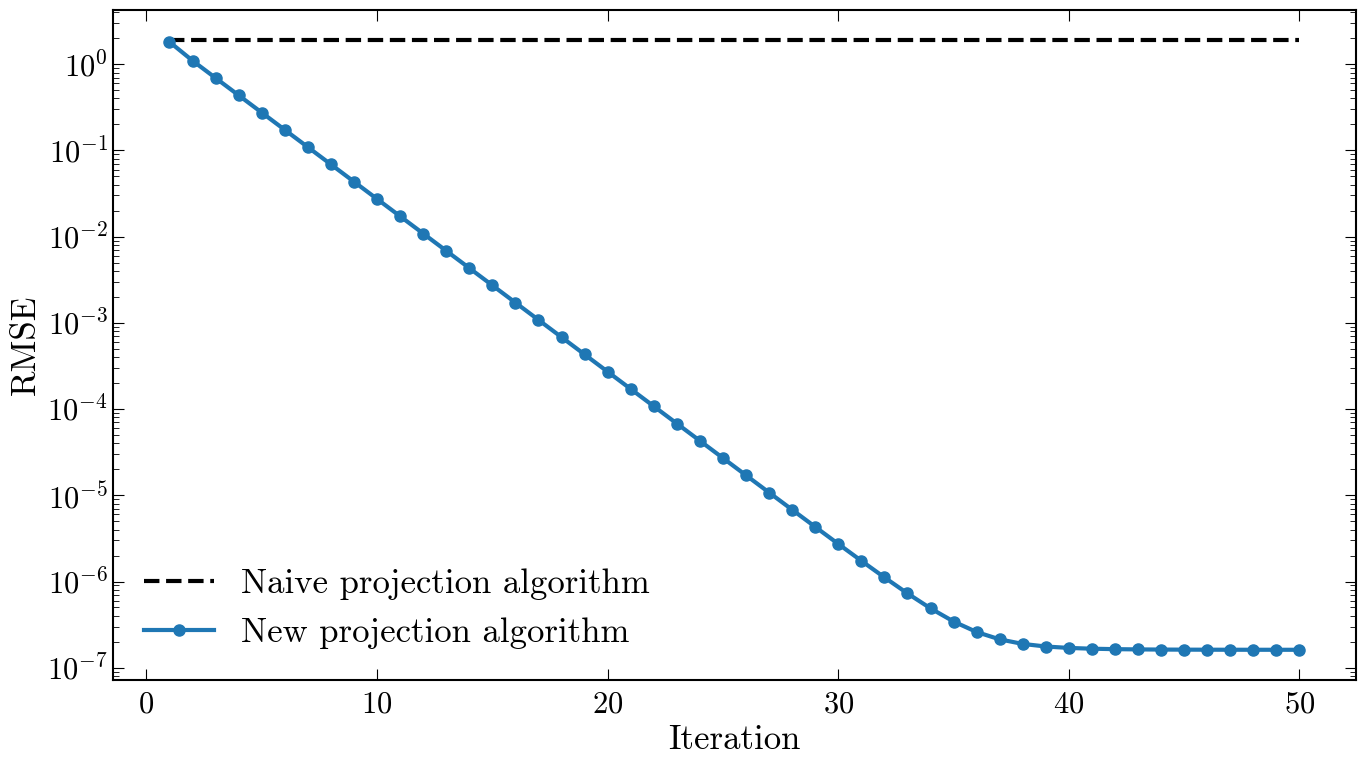

In [25]:

# OPD
cmap = plt.get_cmap('tab10')

text_fontsize = 25
maj_tick_size = 22
min_tick_size = 18

plt.figure(figsize=(14,8))

ax = plt.gca()


plt.plot(
    np.arange(1,len(error_coeffs)+1),
    naive_rmse_error * np.ones(len(error_coeffs)),
    color='black',
    linestyle='--',
    label=r"Naive projection algorithm",
    marker='',
    linewidth=3,
    # alpha=0.85
)

plt.plot(
    np.arange(1,len(error_coeffs)+1),
    error_coeffs,
    color=cmap(0),
    label=r"New projection algorithm",
    linewidth=3,
    markersize=16,
    marker=".",
)



# ax.set_ylim(1, 200)
ax.set_yscale('log')
# ax.yaxis.tick_left()
plt.legend(fontsize=text_fontsize)
plt.ylabel(r'RMSE', fontsize=text_fontsize)
plt.xlabel(r'Iteration', fontsize=text_fontsize)


ax.tick_params(axis='both', which='major', labelsize=maj_tick_size)
ax.tick_params(axis='y', which='minor', labelsize=min_tick_size)
formatter = mtick.LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 0.4))
ax.yaxis.set_minor_formatter(formatter)

plt.tight_layout()
if plot_results:
    plt.savefig(
        '{:s}{:s}'.format(save_dir, 'zk_projection_comparison.pdf'),
        bbox_inches='tight',
        dpi=300
    )
plt.show()


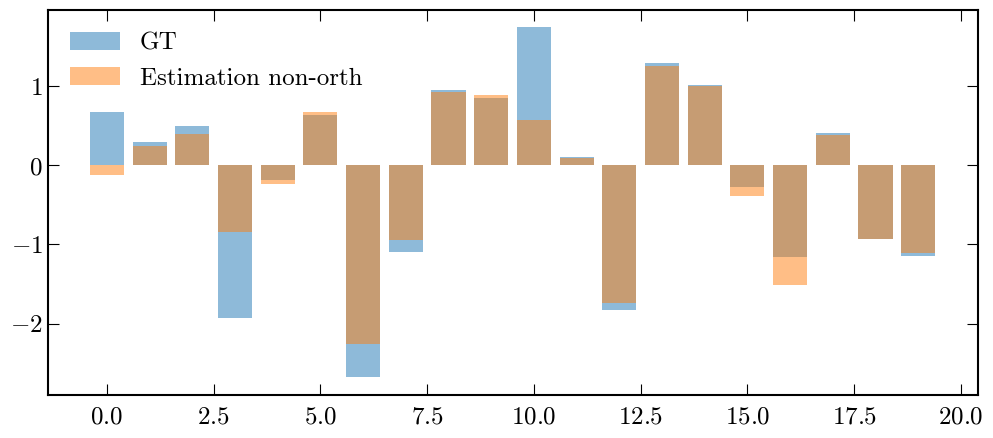

In [26]:

plt.figure(figsize=(12,5))


plt.bar(np.array(range(len(naive_estim_coeffs))), zk_array[0,:,0,0], alpha=0.5, label='GT')
plt.bar(np.array(range(len(naive_estim_coeffs))), naive_estim_coeffs, alpha=0.5, label='Estimation non-orth')
plt.legend()


plt.show()
